In [1]:
from __future__ import print_function, division
import sys
sys.path.insert(0, 'lib')
import numpy as np
import random
import pydicom
import os
import matplotlib.pyplot as plt
import pickle
import math
import pydicom
from shutil import copyfile
import nibabel as nib
import scipy.ndimage as ndimage
from scipy.stats import pearsonr, spearmanr

from utils import make_giant_mat, make_dictionary, make_echo_dict
from difference_map_utils import make_difference
from cluster_utils import threshold_diffmaps, strip_empty_lines, resize
from lesion_utils import *
from inference_utils import run_inference
from make_inference_csv import *
from compare_segmentations import get_dice_scores, get_jaccard_indices, compare_segmentation_masks, compare_region_means, compare_region_changes
from loss_functions import coefficient_of_variation
from figure_utils import plot_mean_val_comparisons


Using TensorFlow backend.


# Specify which subjects you want to analyze using their OAI Patient ID

In [2]:
with open('/data/dominik_data/train_val_test/pid_train.pickle', 'rb') as f:    
    pid_train = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_val.pickle', 'rb') as f:    
    pid_val = pickle.load(f)
      
with open('/data/dominik_data/train_val_test/pid_test.pickle', 'rb') as f:    
    pid_test = pickle.load(f)
    
# with open('/data/dominik_data/train_val_test/pid_test_expert2.pickle', 'rb') as f:
#     pid_expert2 = pickle.load(f)
    
# with open('/data/dominik_data/train_val_test/pid_test_expert2_years.pickle', 'rb') as f:
#     pid_expert2_yrs = pickle.load(f)

with open('/data/dominik_data/train_val_test/pid_test_expert2_round2.pickle', 'rb') as f:
    pid_expert2 = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2_years_round2.pickle', 'rb') as f:
    pid_expert2_yrs = pickle.load(f)

print(pid_test)
print()
print(pid_expert2)
print(pid_expert2_yrs)

['9543086' '9123289' '9260036' '9435250' '9909311' '9518827' '9013634'
 '9245760' '9458093' '9405107' '9120358' '9279874' '9376146' '9529761']

['9435250' '9013634' '9909311' '9279874' '9260036' '9543086' '9123289'
 '9518827' '9245760' '9458093' '9405107' '9120358' '9376146' '9529761']
[4 8 8 4 8 4 8 8 4 8 8 8 8 8]


# Make Pandas Data Frame and CSV file to specify which image files you want to have analyzed


In [3]:
predict_pd = make_expert_csv_all_years(pID=pid_test,img_dir='/data/kevin_data/images', dir_to_save='/data/kevin_data/predicted')

expert1_pd = make_expert_csv_all_years(pID=pid_test, img_dir='/data/kevin_data/images',dir_to_save='/data/kevin_data/qmetric')

# We only have segmentations for one timepoint for the subjects segmented by expert2 and these are nifti files
expert2_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/expert2', 
                                            seg_provided=True, 
                                            seg_format = "numpy")

predict_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/predicted', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')

expert1_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/qmetric', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')
# for f in np.array(expert2_pd.image_dir):
#     print(f)


In [4]:
list(predict_pd.seg_path)[0]


'/data/kevin_data/predicted/segmentations/9543086_4.npy'

# Generate Segmentations and T2 maps for your MESE images
- If you provide a value for the 'expert_pd' argument, it will use your provided segmentations

- If you provide a value for the 'to_segment_pd' argument, it will automatically segment the cartilage and then use that auto-segmentation to generate the T2 maps. By default, this uses our trained model, but model weights can be changed via the 'model_weights_file' argument and the model can be changed by altering the inference.get_model function in inference.py. 

- In addition to generating 3D T2 maps, it also provides the segmentations used to generate those T2 maps as 3D numpy arrays and json files that summarize the avg T2 value in each anatomical region of the cartilage plate

- These results are all saved in the destinations specied in your Pandas dataframe (expert_pd or to_segment_pd) that you made in the previous step

In [ ]:
run_inference(to_segment_pd = predict_pd, model_weight_file = './model_weights/model_weights_quartileNormalization_echoAug.h5')
# run_inference(expert_pd = predict_pd)

# run_inference(expert_pd = expert1_pd)
              
# run_inference(expert_pd = expert2_pd)

# We don't need to generate additional segmentations for the 'predict_subset_pd' or 'expert1_subset_pd' 
# because they are already generated as part of the 'predict_pd' and 'expert1_pd'

-----------------------------------------------------------------------------------
Automatically segmenting images and using those segmentations to analyze MESE MRIs
-----------------------------------------------------------------------------------

/data/kevin_data/images/YR4/9543086/T2


/home/shared/anaconda3/envs/python3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Duration: 8.00996732711792 38.38001871109009 46.38998603820801


/home/shared/anaconda3/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shared/anaconda3/envs/python3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/data/kevin_data/images/YR8/9543086/T2
Duration: 5.336361646652222 30.761003971099854 36.097365617752075
/data/kevin_data/images/YR4/9123289/T2
Duration: 6.15007209777832 32.69177317619324 38.84184527397156
/data/kevin_data/images/YR8/9123289/T2
Duration: 6.141577482223511 25.027135848999023 31.168713331222534
/data/kevin_data/images/YR4/9260036/T2
Duration: 8.051153898239136 39.97786855697632 48.029022455215454
/data/kevin_data/images/YR8/9260036/T2
Duration: 5.238565444946289 29.806280374526978 35.04484581947327
/data/kevin_data/images/YR4/9435250/T2
Duration: 6.163176536560059 33.19331240653992 39.356488943099976
/data/kevin_data/images/YR8/9435250/T2
Duration: 6.193947792053223 26.398370265960693 32.592318058013916
/data/kevin_data/images/YR4/9909311/T2
Duration: 6.785679817199707 37.21684646606445 44.00252628326416
/data/kevin_data/images/YR8/9909311/T2
Duration: 5.249181509017944 31.08030939102173 36.32949090003967
/data/kevin_data/images/YR4/9518827/T2
Duration: 6.78219008445739

In [7]:
# Flip the expert segmentations if you haven't already
# for file in os.listdir('/data/kevin_data/expert2/segmentations'):
#     if file[-4:]=='.npy':
#         temp = np.load(os.path.join('/data/kevin_data/expert2/segmentations',file))
#         temp = np.flip(temp, axis = 0)
#         np.save(os.path.join('/data/kevin_data/expert2/segmentations',file),temp)

# Use cluster analysis to identify cartilage lesions developing over time
<img src="ClusterAnalysisExample.png" alt="Drawing" style="width: 200px;"/>

Find the percentage of the femoral cartilage surface area that is affected by cartilage lesions. In this context, a lesion is a localized area of cartilage that has increased in T2 value over time more than the surrounding area. You can adjust the settings in calculate_group_lesion_area() to make the criteria for lesions more or less strict based on how large a cluster must be and how much the T2 value must increase. 

Lesions are identified using methods adapted from the following manuscript:

Monu, Uchechukwuka D., et al. "Cluster analysis of quantitative MRI T2 and T1ρ relaxation times of cartilage identifies differences between healthy and ACL-injured individuals at 3T." Osteoarthritis and cartilage 25.4 (2017): 513-520.



In [7]:
paths = np.array(predict_pd.t2_projected_path)
paths = [i + '.pickle' for i in paths]
source1_time1 = np.sort([i for i in paths if i[-12]=='4'])
source1_time2 = np.sort([i for i in paths if i[-12]=='8'])

paths = np.array(expert1_pd.t2_projected_path)
paths = [i + '.pickle' for i in paths]
source2_time1 = np.sort([i for i in paths if i[-12]=='4'])
source2_time2 = np.sort([i for i in paths if i[-12]=='8'])

percentLesion_expert1 = calculate_group_lesion_area(timepoint1=source2_time1,
                                                     timepoint2=source2_time2, 
#                                                      value_threshold = 9,
                                                     sigma_multiple = 1,
#                                                      area_value_threshold = 12.4,
                                                     area_fraction_threshold = .01, 
                                                     area_percentile_threshold = None,
                                                     display=False,
                                                     save_path_list=None)

print()
print("--"*10)


percentLesion_predict = calculate_group_lesion_area(timepoint1=source1_time1,
                                                     timepoint2=source1_time2, 
#                                                      value_threshold = 9,
                                                     sigma_multiple = 1,
#                                                      area_value_threshold = 12.4,
                                                     area_fraction_threshold = .01, 
                                                     area_percentile_threshold = None,
                                                     display=False,
                                                     save_path_list = None)

    

# SAVE THE RESIZED PROJECTIONS AND LESION MAPS!





--------------------


# Compare two segmentation approaches (e.g. manual vs automated)
- Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index
- Quantify how closely the downstream T2 measurements correlate for each region using Pearson correlation
- Quantify the mean absolute difference in T2 measurements for each region
- Quantify the agreement in the percentage of the cartilage plate that has lesion via Pearson correlation
- Quantify the agreement in the lesions identified using Dice Score and Jaccard Index

### Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index


Qmetric vs Model: Full test set
0.8514 +/- 0.0287


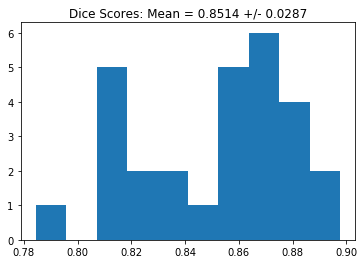

0.7423 +/- 0.0431


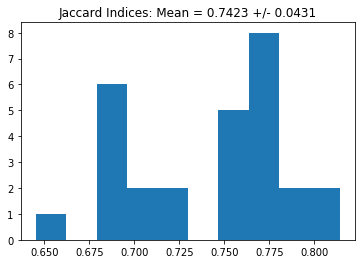

----------------------------------------------------------------------------------------------------

Qmetric vs Model: Test subset
0.8445 +/- 0.0307


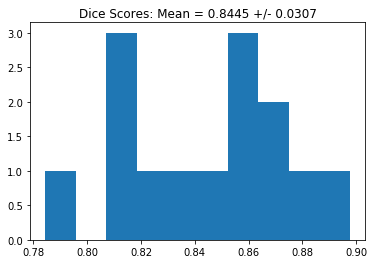

0.7321 +/- 0.0459


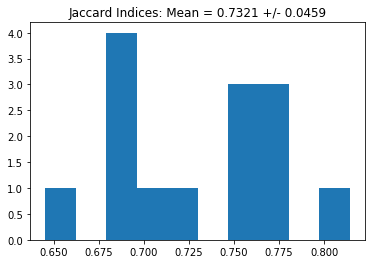

----------------------------------------------------------------------------------------------------
Qmetric vs Expert 2: Test subset
0.7413 +/- 0.0298


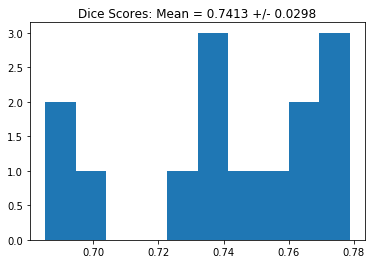

0.5898 +/- 0.0372


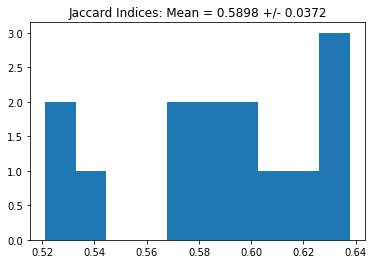

----------------------------------------------------------------------------------------------------
Model vs Expert 2: Test subset
0.7533 +/- 0.0274


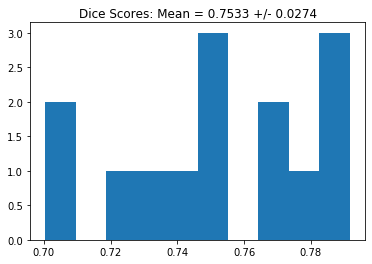

0.605 +/- 0.0349


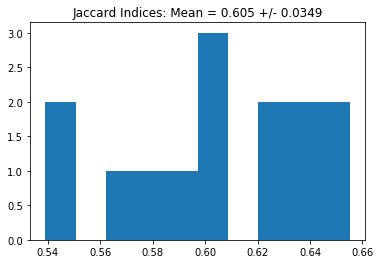

In [8]:
print("Qmetric vs Model: Full test set")
dice_expert1_model, jaccard_expert1_model = compare_segmentation_masks(expert1_pd, 
                                                                       predict_pd, 
                                                                       display = True)

print("-"*100)
print()
print("Qmetric vs Model: Test subset")
dice_expert1_model_subset, jaccard_expert1_model_subset = compare_segmentation_masks(expert1_subset_pd, 
                                                                                     predict_subset_pd, 
                                                                                     display = True)

print("-"*100)
print("Qmetric vs Expert 2: Test subset")

dice_expert1_expert2, jaccard_expert1_expert2 = compare_segmentation_masks(expert1_subset_pd, 
                                                                           expert2_pd, 
                                                                           display = True)

print("-"*100)
print("Model vs Expert 2: Test subset")

dice_expert1_expert2, jaccard_expert1_expert2 = compare_segmentation_masks(predict_subset_pd, 
                                                                           expert2_pd, 
                                                                           display = True)


### See how well they agree in terms of the average T2 value in each cartilage region of each image

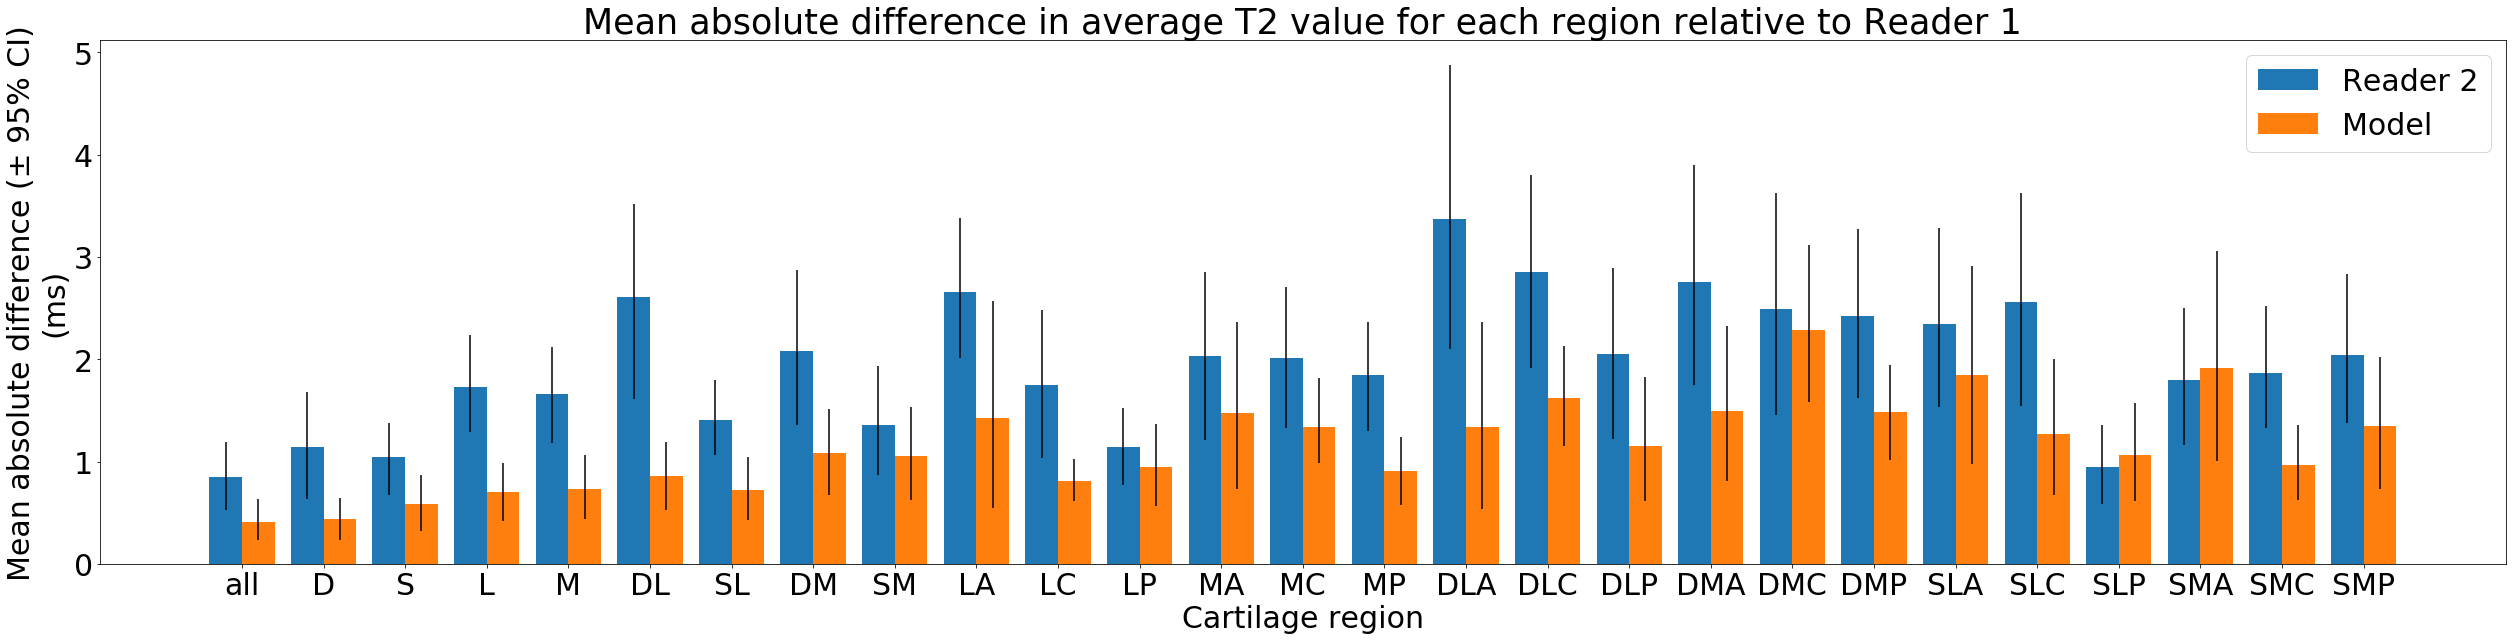

CORRELATION: EXPERT1 vs Model (SUBSET)
all SpearmanrResult(correlation=0.9868131868131869, pvalue=7.379504109330886e-11)
superficial SpearmanrResult(correlation=0.9076923076923077, pvalue=7.3017039968523426e-06)
deep SpearmanrResult(correlation=0.956043956043956, pvalue=9.469782144566512e-08)
SLA SpearmanrResult(correlation=0.6967032967032967, pvalue=0.005628677002967549)
SLC SpearmanrResult(correlation=0.9428571428571428, pvalue=4.4409928509609024e-07)
SLP SpearmanrResult(correlation=0.7054945054945055, pvalue=0.004819557979048519)
SMA SpearmanrResult(correlation=0.7230769230769231, pvalue=0.003475294618094306)
SMC SpearmanrResult(correlation=0.9340659340659341, pvalue=1.0279787693084366e-06)
SMP SpearmanrResult(correlation=0.8769230769230769, pvalue=3.829698105449934e-05)
DLA SpearmanrResult(correlation=0.9032967032967033, pvalue=9.558659401055547e-06)
DLC SpearmanrResult(correlation=0.9164835164835166, pvalue=4.084158819686066e-06)
DLP SpearmanrResult(correlation=0.7362637362637363,

In [9]:
correlation_dict_e1_m, abs_diff_dict_e1_m, cv_e1_m, t_e1_m, cohen_e1_m = compare_region_means(list(expert1_pd.t2_region_json_path), 
                                                                            list(predict_pd.t2_region_json_path), 
                                                                            results_path=None,
                                                                            correlation_method = 'spearman',
                                                                            bland_altman = False)

correlation_dict_e1_m_subset, abs_diff_dict_e1_m_subset, cv_e1_m_subset, t_e1_m_subset, cohen_e1_m_subset = compare_region_means(list(expert1_subset_pd.t2_region_json_path), 
                                                                                                list(predict_subset_pd.t2_region_json_path), 
                                                                                                results_path=None,
                                                                                                correlation_method = 'spearman')

correlation_dict_e1_e2, abs_diff_dict_e1_e2, cv_e1_e2, t_e1_e2, cohen_e1_e2 = compare_region_means(list(expert1_subset_pd.t2_region_json_path), 
                                                                            list(expert2_pd.t2_region_json_path), 
                                                                            results_path=None,
                                                                            correlation_method = 'spearman')

correlation_dict_e2_m, abs_diff_dict_e2_m, cv_e2_m, t_e2_m, _cohen_e1_e2 = compare_region_means(list(expert2_pd.t2_region_json_path), 
                                                                            list(predict_subset_pd.t2_region_json_path), 
                                                                            results_path=None,
                                                                            correlation_method = 'spearman')

plot_mean_val_comparisons(abs_diff_dict_e1_e2, 
                          abs_diff_dict_e1_m_subset, 
                          'Reader 2', 
                          'Model',
                          error_bar='ci')

# plot_mean_val_comparisons(abs_diff_dict_e1_e2, 
#                           abs_diff_dict_e1_m_subset, 
#                           'Reader 2', 
#                           'Model',
#                           error_bar='ci')

# plot_mean_val_comparisons(abs_diff_dict_e1_e2, 
#                           abs_diff_dict_e2_m, 
#                           'Reader 1', 
#                           'Model',
#                           error_bar = 'ci')


roi_list = np.array(['SLA', 'SLC', 'SLP', 'SMA', 'SMC', 'SMP', 'DLA', 'DLC', 'DLP', 'DMA', 'DMC', 'DMP'])
print("CORRELATION: EXPERT1 vs Model (SUBSET)")
roi_corr_mean = 0
for k,v in correlation_dict_e1_m_subset.items():
    print(k, v)
    if k in roi_list:
        roi_corr_mean += v[0]
roi_corr_mean = roi_corr_mean / len(roi_list)
print()
print("ROI CORR MEAN:", roi_corr_mean)
print()    
print()

print("Mean Abs Error: EXPERT1 vs Model (SUBSET")
roi_mae_mean = 0
for k,v in abs_diff_dict_e1_m_subset.items():
    print(k, v)
    if k in roi_list:
        roi_mae_mean += v[0]
roi_mae_mean = roi_mae_mean / len(roi_list)
print()
print("ROI MAE MEAN:", roi_mae_mean)
print()    
print()   
print()
print("Coefficient of Variation: EXPERT1 vs EXPERT2")
for k,v in cv_e1_e2.items():
    print(k, v)
    
    
    
print()
print("Cohen's D: EXPERT1 vs EXPERT2")
for k,v in cohen_e1_e2.items():
    print(k, v)

    

### See how well they agree in terms of the average T2 change over time in each cartilage region of each image

In [ ]:
expert1_regions = list(expert1_pd.t2_region_json_path)
model_regions = list(predict_pd.t2_region_json_path)


source1_regions1 = [i for i in expert1_regions if i[-6]=='4']# and '9120358' not in i]
source1_regions2 = [i for i in expert1_regions if i[-6]=='8']#and '9120358' not in i]
source2_regions1 = [i for i in model_regions if i[-6]=='4']#and '9120358' not in i]
source2_regions2 = [i for i in model_regions if i[-6]=='8']#and '9120358' not in i]

if len(source1_regions1)==len(source1_regions2):
    catch = compare_region_changes(source1_regions1,
                                   source1_regions2,
                                   source2_regions1,
                                   source2_regions2, 
                                   results_path=None,
                                   correlation_method = 'spearman',
                                   bland_altman = True)  
    
    (change_correlation_dict, change_mean_abs_diff_dict, change_cv_dict, change_ttest_dict, change_dict, change_cohen) = catch
    
print("CORRELATION EXPERT 1 VS MODEL")
for k,v in change_correlation_dict.items():
    print(k, v)
    

print()
print("MEAN ABS DIFFERENCE EXPERT 1 VS MODEL")
for k,v in change_mean_abs_diff_dict.items():
    print(k, v)
print()

    
print()
print("MEAN CHANGE ACCORDING TO EXPERT 1")
for k,v in change_dict[1].items():
    print(k, np.mean(v))
    
    
print()
print("COHEN's D ACCORDING TO EXPERT 1")
for k,v in change_cohen.items():
    print(k, np.mean(v))


for k in change_dict[1].keys():
    plt.scatter(change_dict[1][k],change_dict[2][k]) 
    plt.title(k)
    plt.plot([0,0],[-5,5],'orange')
    plt.plot([-5,5],[0,0], 'orange')
    plt.plot([-1.73,-1.73],[0,-4])
    plt.plot([1.73, 1.73],[0,-4])
    plt.plot([-.61,-.61],[0,-4])
    plt.plot([.61, .61],[0,-4])
    plt.show()


### See how well they agree in terms of the cartilage lesions that are identified as developing over time

In [ ]:
plt.scatter(percentLesion_expert1, percentLesion_predict)
plt.title("Correlation:" + str(spearmanr(percentLesion_expert1, percentLesion_predict)))
plt.xlabel("Source 1: Fraction of cartilage affected")
plt.ylabel("Source 2: Fraction of cartilage affected")
plt.plot([.03,.15],[.03,.15])
plt.plot(np.unique(percentLesion_expert1), np.poly1d(np.polyfit(percentLesion_expert1, percentLesion_predict, 1))(np.unique(percentLesion_expert1)))
plt.legend(['unity','best fit','data points'])
plt.show()


bias_raw = np.mean(((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))
StD_raw = np.std(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))
Mean_Abs_error = np.mean(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))
StD_Abs_error = np.std(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))


print()    
print("Raw Error:", bias_raw, "+/-", StD_raw)
print("Mean absolute error:", Mean_Abs_error)
print("StD absolute error:", StD_Abs_error)

bias_relative = np.mean(((np.array(percentLesion_expert1) - np.array(percentLesion_predict))/np.array(percentLesion_expert1)))
StD_relative = np.std(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))/np.array(percentLesion_expert1)))
    
print()    
print("Relative Error:", bias_relative, "+/-", StD_relative)
 
print("Mean Lesion Coverage for Expert 1:", np.mean(percentLesion_expert1))
print("Mean Lesion Coverage for Model:", np.mean(percentLesion_predict))



In [ ]:
np.mean(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))



In [ ]:
a = np.load('/data/kevin_data/qmetric/t2maps/9120358_4.npy')
plt.imshow(a[19])

In [ ]:
with open('/data/kevin_data/qmetric/t2_projected/9909311_4.npy.pickle', 'rb') as handle:
    dict_a = pickle.load(handle)

with open('/data/kevin_data/qmetric/t2_projected/9909311_8.npy.pickle', 'rb') as handle:
    dict_b = pickle.load(handle)
    
a = make_projection_proportional(dict_a)
b = make_projection_proportional(dict_b)
a,b = align_projections(a,b)

In [ ]:
plt.imshow(a)
plt.show()

In [ ]:
plt.imshow(b)
plt.show()

In [ ]:
num_pix = np.sum(b!=0)
where_b = np.where(b)
where_a = np.where(a)

dmap = np.zeros_like(b)
for i in range(num_pix):
    t2_b = b[where_b[0][i], where_b[1][i]]
    
    distances_r = where_a[0] - where_b[0][i]
    distances_c = where_a[1] - where_b[1][i]
    distances = np.sqrt(distances_r**2 + distances_c**2)
    index = np.argmin(distances)
    t2_a = a[where_a[0][index], where_a[1][index]]
    
    change = t2_b - t2_a
    dmap[where_b[0][i], where_b[1][i]] = change
plt.imshow(dmap)

In [ ]:
from difference_map_utils import eroded_and_mask
mask = eroded_and_mask(dmap!=0,dmap!=0)
dmap = dmap*mask
plt.imshow(dmap)

In [ ]:
a= np.array([10,2,1,5])
i = np.argsort(a)
a[i]

In [ ]:
a=np.array([[10,1,5,3],[8,9,7,2],[1,2,3,4],[7,6,5,4]])
a

In [ ]:
a[[0,0,1],[2,3,3]]